In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
os.chdir('C:/Users/Surya/Desktop/Lab Programs/NNDL/New folder/Temperature Forecasting')

In [3]:
data_dir = '.'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
lines[:] = lines[:10000]
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
9999


In [17]:
lines

['01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30',
 '01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10',
 '01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60',
 '01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.00',
 '01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.30',
 '01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.70',
 '01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.80,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.50',
 '01.01.2009 01:20:00,996.50,-7.62,265.81,-8.36,94.40,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,0.50,118.60',
 '01.01.2009 01:30:00,996.50,-7.91,265.52,-8.73,93.80,3.36,3.15,0.21,1.97,3.16,1307.17,0.28,0.75,188.50',
 '01.01.2009 01:40:00,996.53,-8.43,264.99,-9.3

### Parsing the Data

In [5]:
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

### Plotting the Temperature TimeSeries

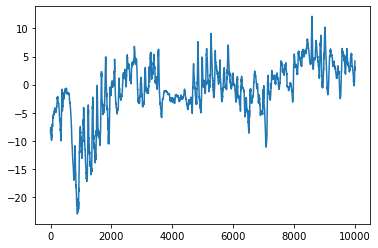

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt


temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

### Plotting the first 10 days of the temperature timeseries

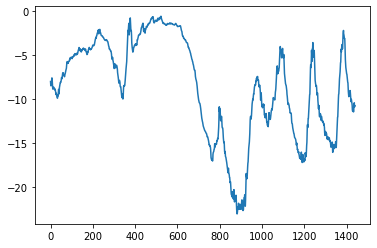

In [7]:
plt.plot(range(1440), temp[:1440])

### Normalize the data

In [8]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

 ### Generator Yielding Time Series Samples and their Targets

In [9]:
float_data.shape

(9999, 14)

In [10]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
            min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows)))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
    

### Preparing the training, validation and test generators

In [11]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

In [12]:
train_gen = generator(float_data,
                     lookback = lookback,
                     delay = delay,
                     min_index = 0,
                     max_index = 2000,
                     shuffle=True,
                     step = step,
                     batch_size = batch_size)

val_gen = generator(float_data,
                   lookback = lookback,
                   delay = delay,
                   min_index = 2001,
                   max_index = 3000,
                   step = step,
                   batch_size=batch_size)

test_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=3001,
                    max_index=None,
                    step = step,
                    batch_size = batch_size)

In [13]:
val_steps = (300000 - 200001 - lookback)
test_steps = (len(float_data) - 300001 - lookback)

### Computing the common-sense baseline MAE

In [14]:
def evaluation_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluation_naive_method()

C:\Users\Surya\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Surya\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan


### Converting the MAE back to a celcius error

In [15]:
celsius_mae = 0.29 * std[1]
print(celsius_mae)

1.4886517121153695


### Training and evaluating a densely connected model

In [16]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/20


C:\Users\Surya\AppData\Local\Temp\ipykernel_3180\3417593176.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 102s 202ms/step - loss: 0.2356 - val_loss: 0.0000e+00
Epoch 2/20
500/500 [==============================] - 100s 201ms/step - loss: 0.0861 - val_loss: 0.0000e+00
Epoch 3/20
500/500 [==============================] - 102s 204ms/step - loss: 0.0684 - val_loss: 0.0000e+00
Epoch 4/20
500/500 [==============================] - 98s 196ms/step - loss: 0.0618 - val_loss: 0.0000e+00
Epoch 5/20
500/500 [==============================] - 103s 206ms/step - loss: 0.0578 - val_loss: 0.0000e+00
Epoch 6/20
500/500 [==============================] - 103s 206ms/step - loss: 0.0556 - val_loss: 0.0000e+00
Epoch 7/20
500/500 [==============================] - 103s 206ms/step - loss: 0.0552 - val_loss: 0.0000e+00
Epoch 8/20
500/500 [==============================] - 103s 207ms/step - loss: 0.0536 - val_loss: 0.0000e+00
Epoch 9/20
500/500 [==============================] - 103s 207ms/step - loss: 0.0533 - val_loss: 0.0000e+00
Epoch 10/20
500/500 [===================

In [18]:
pd.read_csv('jena_climate_2009_2016.csv')

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412166,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
412167,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
412168,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
412169,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8
